In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

In [53]:
# Get all Weather data first
# List all files in the directory
folder_path = "F:/Libraries/My Documents/UM/Milestone II/"
files = os.listdir(folder_path)

# Filter files that end with "cleaned2"
cleaned_files = [file for file in files if file.endswith("cleaned2.csv")]

# Read and concatenate the files
weather_data_df = pd.DataFrame()
for file in cleaned_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, dtype={'STATION': 'string'})
    weather_data_df = pd.concat([weather_data_df, df], ignore_index=True)

weather_data_df = weather_data_df[['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'STATE', 'TEMP']]
print(weather_data_df.columns)
print(weather_data_df.head(5))

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'STATE', 'TEMP'], dtype='object')
       STATION        DATE  LATITUDE  LONGITUDE STATE  TEMP
0  72037392824  2019-01-01  28.00028  -82.16417    FL  71.8
1  72037392824  2019-01-02  28.00028  -82.16417    FL  73.1
2  72037392824  2019-01-03  28.00028  -82.16417    FL  73.0
3  72037392824  2019-01-04  28.00028  -82.16417    FL  73.2
4  72037392824  2019-01-05  28.00028  -82.16417    FL  64.6


In [54]:
# Get the plant location data
pp1 = pd.read_csv("C:/Users/Administrator/Desktop/Plant_Location_MI.csv")
pp2 = pd.read_csv("C:/Users/Administrator/Desktop/Plant_Location_WA.csv")
pp3 = pd.read_csv("C:/Users/Administrator/Desktop/Plant_Location_TX.csv")
pp4 = pd.read_csv("C:/Users/Administrator/Desktop/Plant_Location_FL.csv")

power_plants_df = pd.concat([pp1,pp2,pp3,pp4], ignore_index=True)
power_plants_df = power_plants_df[['period', 'primeMover', 'Latitude', 'Longitude', 'state']]
power_plants_df.head(5)

,period,primeMover,Latitude,Longitude,state
0,2020-01,ALL,43.266389,-82.619167,MI
1,2020-12,ALL,43.266389,-82.619167,MI
2,2023-08,ALL,43.266389,-82.619167,MI
3,2023-04,ALL,43.266389,-82.619167,MI
4,2023-02,ALL,43.266389,-82.619167,MI


In [55]:
# Convert the 'DATE' column to datetime format in weather_data
weather_data = weather_data[pd.to_datetime(weather_data['DATE'], errors='coerce').notna()]
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Convert the 'period' column to datetime format in power_plants_df
power_plants_df['period'] = pd.to_datetime(power_plants_df['period'], format='%Y-%m')
power_plants_df = power_plants_df[power_plants_df['period']>=pd.to_datetime('2019-01-01')]
power_plants_df = power_plants_df[power_plants_df['primeMover']=="ALL"]
power_plants_df=power_plants_df.dropna()

# Round latitude and longitude columns for better matching
weather_data['LATITUDE'] = weather_data['LATITUDE'].round(4)
weather_data['LONGITUDE'] = weather_data['LONGITUDE'].round(4)
power_plants_df['Latitude'] = power_plants_df['Latitude'].round(4)
power_plants_df['Longitude'] = power_plants_df['Longitude'].round(4)

power_plants_df.head(5)

,period,primeMover,Latitude,Longitude,state
0,2020-01-01,ALL,43.2664,-82.6192,MI
1,2020-12-01,ALL,43.2664,-82.6192,MI
2,2023-08-01,ALL,43.2664,-82.6192,MI
3,2023-04-01,ALL,43.2664,-82.6192,MI
4,2023-02-01,ALL,43.2664,-82.6192,MI


In [56]:
# Aggregate the weather data to make it more manageable
columns_to_aggregate = ['LATITUDE', 'LONGITUDE', 'DATE', 'STATE', 'TEMP']
weather_subset = weather_data[columns_to_aggregate]

# Group by the monthly period (to match the natural gas data) and aggregate weather data for the selected columns
aggregated_weather_data = weather_subset.groupby(['LATITUDE', 'LONGITUDE', 'STATE', pd.Grouper(key='DATE', freq='MS')]).agg(['mean']).reset_index().droplevel(1, axis=1)
aggregated_weather_data.head(5)

,LATITUDE,LONGITUDE,STATE,DATE,TEMP
0,24.46,-81.88,FL,2019-01-01,69.954839
1,24.46,-81.88,FL,2019-02-01,74.864286
2,24.46,-81.88,FL,2019-03-01,74.048387
3,24.46,-81.88,FL,2019-04-01,76.973333
4,24.46,-81.88,FL,2019-05-01,80.412903


In [57]:
# Function to find the closest weather station for each power plant
# input: data for a power plant, weather station data
# output: index of the nearest weather station
def find_nearest_weather_station(row, weather_data):
    # Filter weather stations based on the same period
    filtered_weather_data = weather_data[weather_data['DATE'] == row['period']]
    if filtered_weather_data.empty:
        return None
    
    # Calculate the Euclidean distance between the power plant and each filtered weather station
    distances = ((filtered_weather_data['LATITUDE'] - row['Latitude'])**2 + (filtered_weather_data['LONGITUDE'] - row['Longitude'])**2)**0.5
    # Find the index of the weather station with the minimum distance
    nearest_station_index = distances.idxmin()
    # Get the data for the nearest weather station
    nearest_station = filtered_weather_data.loc[nearest_station_index]
    
    return nearest_station

In [58]:
# Apply the custom function to each power plant row
closest_weather_stations = power_plants_data.apply(lambda row: find_nearest_weather_station(row, aggregated_weather_data), axis=1)

In [59]:
print(aggregated_weather_data.head())

   LATITUDE  LONGITUDE STATE       DATE       TEMP
0     24.46     -81.88    FL 2019-01-01  69.954839
1     24.46     -81.88    FL 2019-02-01  74.864286
2     24.46     -81.88    FL 2019-03-01  74.048387
3     24.46     -81.88    FL 2019-04-01  76.973333
4     24.46     -81.88    FL 2019-05-01  80.412903


In [60]:
print(closest_weather_stations.head())

   LATITUDE  LONGITUDE STATE       DATE       TEMP
0   43.4167   -82.5333    MI 2020-01-01  30.729032
1   43.4167   -82.5333    MI 2020-12-01  32.380645
2   43.0100   -82.4200    MI 2023-08-01  67.809677
3   43.0100   -82.4200    MI 2023-04-01  47.196667
4   43.0100   -82.4200    MI 2023-02-01  31.228571


In [62]:
statelist = closest_weather_stations['STATE'].unique()

In [63]:
print(statelist)

['MI' 'WA' 'TX' 'FL']


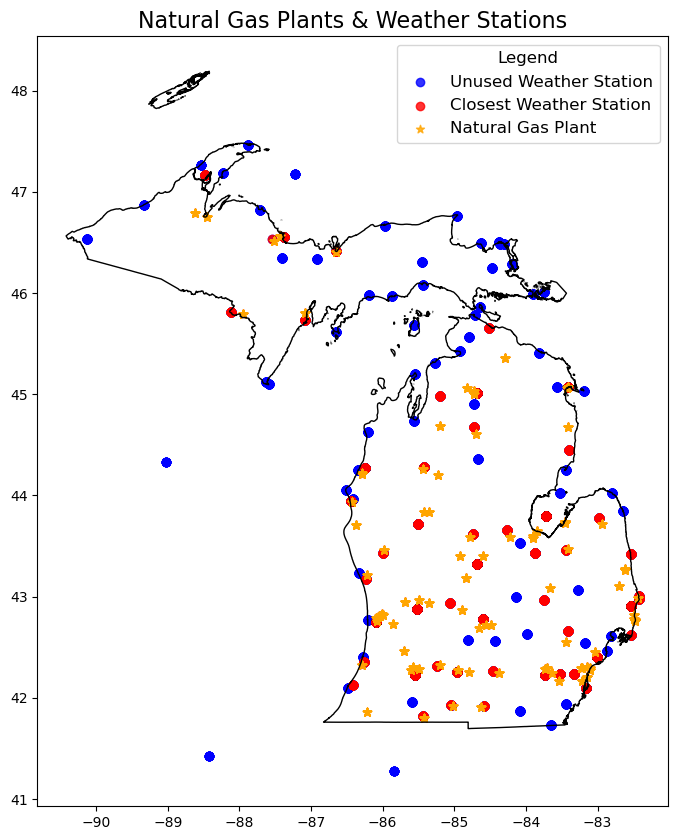

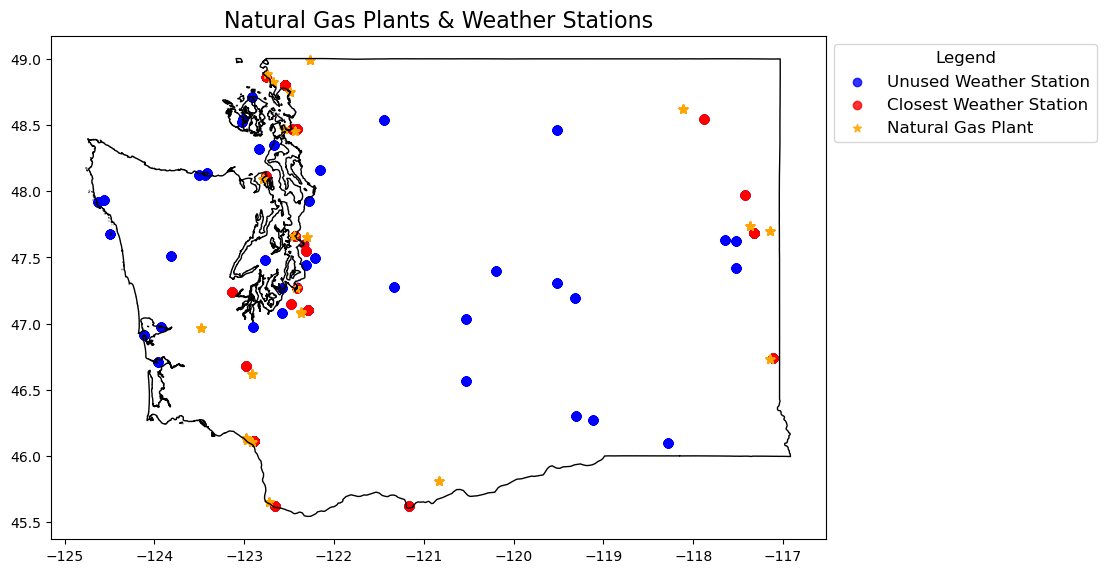

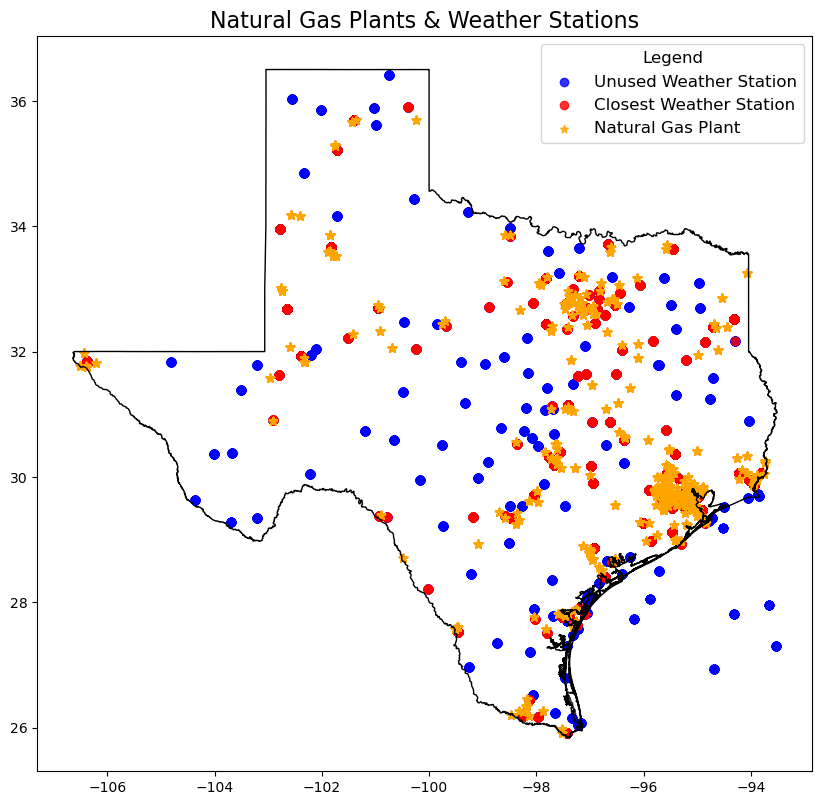

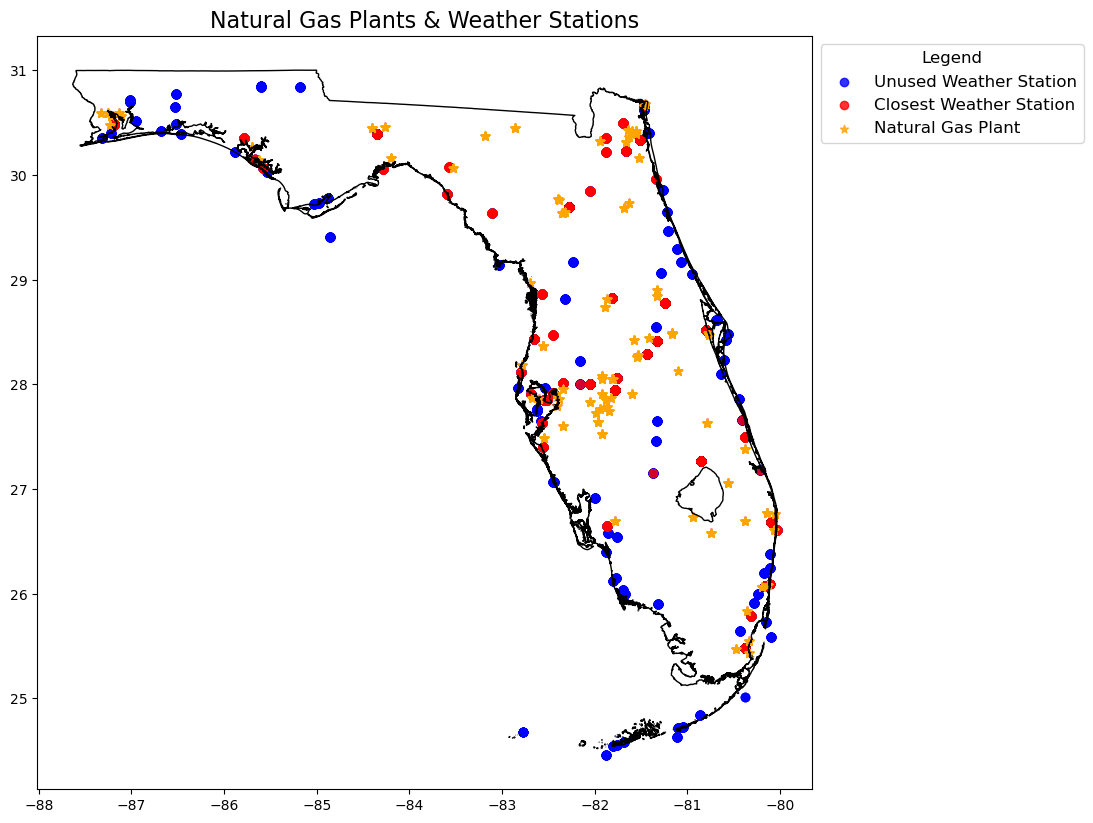

In [73]:
# The s_05mr24.zip file contains the files necessary for Geopandas to map the United States 
# and was obtained from https://www.weather.gov/gis/USStates
usa_gdf = gpd.read_file('C:/Users/Administrator/Desktop/s_05mr24')
for state in statelist:
    # get the power plants, weather_stations, and map for each state
    state_power_plants = power_plants_df.loc[power_plants_df['state'] == state]
    state_weather_stations = aggregated_weather_data.loc[aggregated_weather_data['STATE'] == state]
    state_closest_ws = closest_weather_stations.loc[closest_weather_stations['STATE'] == state]    
    state_gdf = usa_gdf.loc[usa_gdf['STATE'] == state]
    
    # create the Geodataframes for the power plants and weather stations
    power_plants_gdf = gpd.GeoDataFrame(state_power_plants, 
                                        geometry=gpd.points_from_xy(state_power_plants.Longitude, state_power_plants.Latitude))
    ws_gdf = gpd.GeoDataFrame(state_weather_stations, 
                              geometry=gpd.points_from_xy(state_weather_stations.LONGITUDE, state_weather_stations.LATITUDE))
    closest_gdf = gpd.GeoDataFrame(state_closest_ws,
                                   geometry=gpd.points_from_xy(state_closest_ws.LONGITUDE, state_closest_ws.LATITUDE))
    
    # set up the plot
    my_fig, my_ax = plt.subplots(figsize=(10,10))
    my_ax.set_title('Natural Gas Plants & Weather Stations', fontdict={'fontsize': '16'})
    
    # draw the weather stations
    ws_gdf.plot(ax=my_ax, color='blue', marker='o', alpha=0.8)
    
    # draw the closest weather stations
    closest_gdf.plot(ax=my_ax, color='red', marker='o', alpha=0.8)

    # draw the power plants
    power_plants_gdf.plot(ax=my_ax, color='orange', marker='*', alpha=0.8)
    
    # draw the map of the state
    state_gdf.plot(ax=my_ax, color='None', edgecolor='black')

    # create the legend
    legend = my_ax.legend(['Unused Weather Station', 'Closest Weather Station', 'Natural Gas Plant'], \
                          title='Legend', fontsize=12, \
                          bbox_to_anchor=(1.0, 1.0))
    plt.setp(legend.get_title(), fontsize=12)